In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerias

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as kr
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image

In [8]:
brain_df = pd.read_csv('drive/MyDrive/PROYECTO IA - DETECCION DE TUMORES CEREBRRALES/data_cerebro/Brain Tumor.csv',usecols=[0,1])
brain_df.head()

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


In [9]:
brain_df.isna().sum()

Image    0
Class    0
dtype: int64

In [10]:
brain_df['Class'].value_counts()

0    2079
1    1683
Name: Class, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


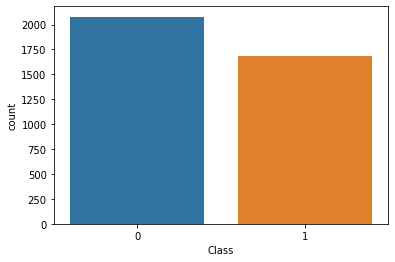

In [11]:
#plot the value count
sns.countplot(brain_df['Class'])

In [12]:
path_list = []
base_path = 'drive/MyDrive/PROYECTO IA - DETECCION DE TUMORES CEREBRRALES/data_cerebro/Brain Tumor/Brain Tumor'
for entry in os.listdir(base_path):
    path_list.append( os.path.join(base_path,entry))

In [13]:
#create path dictonary and then map itto brain_df['pathes']
pathes_dict={os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
brain_df['pathes'] = brain_df['Image'].map(pathes_dict.get)

In [14]:
brain_df.head()

,Image,Class,pathes
0,Image1,0,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...
1,Image2,0,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...
2,Image3,1,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...
3,Image4,1,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...
4,Image5,0,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...


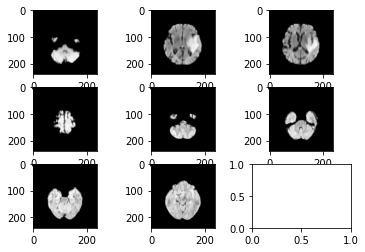

In [15]:
for x in range (0 ,9):
    img = imread(brain_df['pathes'][x])
    plt.imshow(img)
    plt.subplot(3,3,x+1)

In [16]:
from PIL.Image import open
brain_df['pixels']=brain_df['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))))

In [17]:
brain_df.head()

,Image,Class,pathes,pixels
0,Image1,0,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,drive/MyDrive/PROYECTO IA - DETECCION DE TUMOR...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


# Preprocesamiento

In [18]:
image_list = []
for i in range(0,len(brain_df)):
    # load image
    brain_img = brain_df['pixels'][i].astype(np.float32)
    img_array = image.img_to_array(brain_img)
     # append to list of all images
    image_list.append(kr.applications.mobilenet_v2.preprocess_input(img_array))
    
# convert image list to single array
# Our feature
X = np.array(image_list)

# print shape of X
print(X.shape)

(3762, 224, 224, 3)


In [19]:
# get the class label as np.array
y = np.array(brain_df.Class)

In [20]:
print('The shape of the X : ' + str(X.shape))
print('The shape of the y: ' + str(y.shape))

The shape of the X : (3762, 224, 224, 3)
The shape of the y: (3762,)


In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(X_train.shape[0]))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(X_test.shape[0]))

The shape of the X_train : (2633, 224, 224, 3)
The size of the X_train : 2633
The shape of the X_test : (1129, 224, 224, 3)
The size of the X_test: 1129


# Build model(MobileNet)

In [22]:
num_classes = 1
model = Sequential()
model.add(MobileNetV2(input_shape=(224, 224, 3),weights="imagenet",include_top=False))
model.add(kr.layers.GlobalAveragePooling2D())
model.add(Dense(num_classes, activation='sigmoid',name='preds'))
model.layers[0].trainable= False
# show model summary
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
model.compile(
    # set the loss as binary_crossentropy
    loss=kr.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=kr.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

# mock-train the model 
model.fit(
    X_train[:,:,:,:],
    y_train[:],
    epochs=100,
    verbose=1,
    validation_data=(X_test[:,:,:,:], y_test[:])
)

Epoch 1/100
83/83 [==============================] - 15s 67ms/step - loss: 0.7412 - accuracy: 0.5157 - val_loss: 0.6011 - val_accuracy: 0.6820
Epoch 2/100
83/83 [==============================] - 5s 57ms/step - loss: 0.5595 - accuracy: 0.7348 - val_loss: 0.5288 - val_accuracy: 0.7617
Epoch 3/100
83/83 [==============================] - 5s 58ms/step - loss: 0.4936 - accuracy: 0.7888 - val_loss: 0.4921 - val_accuracy: 0.7927
Epoch 4/100
83/83 [==============================] - 5s 57ms/step - loss: 0.4517 - accuracy: 0.8371 - val_loss: 0.4644 - val_accuracy: 0.8060
Epoch 5/100
83/83 [==============================] - 5s 57ms/step - loss: 0.4370 - accuracy: 0.8290 - val_loss: 0.4455 - val_accuracy: 0.8113
Epoch 6/100
83/83 [==============================] - 5s 57ms/step - loss: 0.4118 - accuracy: 0.8340 - val_loss: 0.4314 - val_accuracy: 0.8149
Epoch 7/100
83/83 [==============================] - 5s 58ms/step - loss: 0.3961 - accuracy: 0.8495 - val_loss: 0.4191 - val_accuracy: 0.8255
Epoch

In [24]:
model.save("model_brain.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
pretrained_cnn = keras.models.load_model('./model_brain.h5')

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(X_test,y_test)
# print loss score
print('loss:',eval_score[0])
# print accuracy score
print('accuracy:',eval_score[1] )

36/36 [==============================] - 2s 41ms/step - loss: 0.2771 - accuracy: 0.8884
loss: 0.2771458029747009
accuracy: 0.8883967995643616


In [26]:
y_pred = pretrained_cnn.predict_classes(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
from sklearn.metrics import confusion_matrix , classification_report
target_classes = ['No Tumor','Tumor']
classification_report(y_test , y_pred , output_dict = True
                      , target_names=target_classes)

{'No Tumor': {'f1-score': 0.895,
  'precision': 0.9055649241146712,
  'recall': 0.8846787479406919,
  'support': 607},
 'Tumor': {'f1-score': 0.8809073724007562,
  'precision': 0.8694029850746269,
  'recall': 0.89272030651341,
  'support': 522},
 'accuracy': 0.8883968113374667,
 'macro avg': {'f1-score': 0.8879536862003781,
  'precision': 0.887483954594649,
  'recall': 0.8886995272270509,
  'support': 1129},
 'weighted avg': {'f1-score': 0.8884841881250617,
  'precision': 0.8888452321935878,
  'recall': 0.8883968113374667,
  'support': 1129}}

In [28]:
confusion_matrix(y_test , y_pred )

array([[537,  70],
       [ 56, 466]])

# Prediccion de un tumor

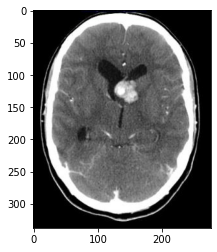

(338, 276, 3)

In [30]:
import cv2

prueba_1 = cv2.imread('drive/MyDrive/PROYECTO IA - DETECCION DE TUMORES CEREBRRALES/data de prueba/N1.JPG')
plt.imshow(prueba_1)
plt.show()
prueba_1.shape

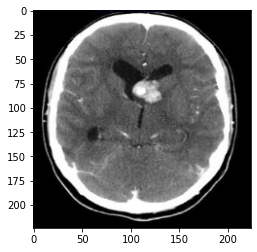

(224, 224, 3)

In [31]:
prueba = cv2.resize(prueba_1, (224,224))
plt.imshow(prueba)
plt.show()
prueba.shape

In [32]:
test = prueba.reshape((1,prueba.shape[0], prueba.shape[1], prueba.shape[2]))
test.shape

(1, 224, 224, 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


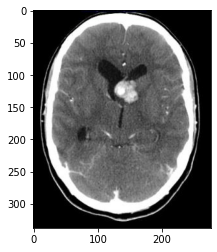

No tiene tumor


In [33]:
predictions = pretrained_cnn.predict_classes(test)

plt.figure()
plt.imshow(prueba_1)
plt.show()

if(predictions==1):
    print("Tiene tumor")
elif(predictions==0):
    print("No tiene tumor")
else:
    print("error")